# GTZAN dataset preprocessing

## Download

We downloaded the GTZAN audio files from
```
http://marsyasweb.appspot.com/download/data_sets/
```
and the GTZAN rhythm files from
```
http://anasynth.ircam.fr/home/media/GTZAN-rhythm/
```
We placed them in
```
./data/GTZAN/genres
./data/GTZAN/rhythm
```
respectively.

## Paths

Next are a couple of useful methods to access the GTZAN's files and the data that we will create later.

In [1]:
from GTZAN import *

## Compute the onsets and select the ones that are first beat

We compute the onsets using `librosa`.

### An example

We start with an example. This section can be skipped.

In [15]:
import librosa
import numpy as np
import pandas as pd
sr = 44100
hl = 512

import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

We first explain what we are doing with an example. Let's import the 37th song in the jazz category.

In [165]:
s = 'blues'
n = np.random.randint(100)
print(filename(s, n))

blues.00033


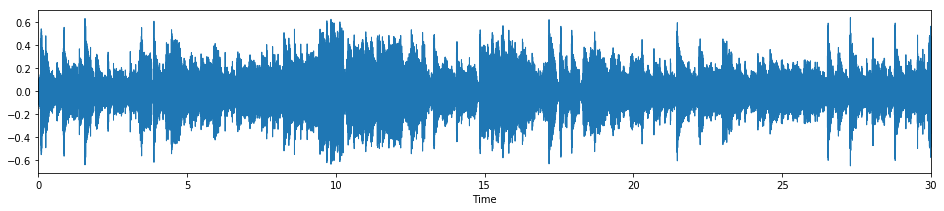

In [166]:
wav = librosa.load(filename_audio(s, n), sr)[0]
plt.figure(figsize=(16, 3))
librosa.display.waveplot(wav, sr);
Audio(wav, rate=sr)

We then compute the onsets using `librosa`'s algorithm.

In [167]:
onsets = librosa.onset.onset_detect(wav, sr, hop_length=hl)
onsets_times = librosa.frames_to_time(onsets, sr, hl)

They are first expressed in frames, where one frame is the same duration as `hl` (hop length) samples. We also converted them in seconds.

In [168]:
print("First five onsets (in seconds):", onsets_times[:5])
print(f"Total number of onsets detected: {len(onsets)}")

First five onsets (in seconds): [0.06965986 0.24380952 0.44117914 0.6153288  0.73142857]
Total number of onsets detected: 157


Let's visualize them on top of the wav, for the first 5 seconds:

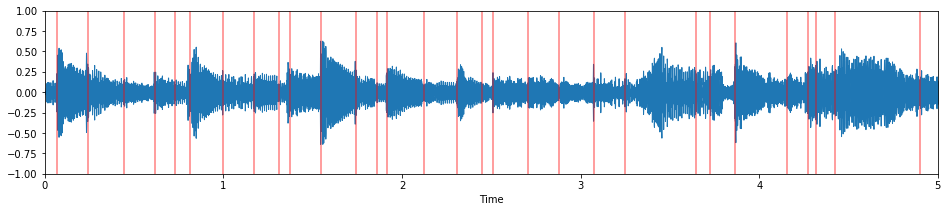

In [169]:
duration = 5
plt.figure(figsize=(16, 3))
librosa.display.waveplot(wav[:duration*sr], sr)
plt.ylim(-1, 1)
plt.vlines(onsets_times, -1, 1, color='r', alpha=0.5);

Although not every first beat is marked by on onset, a large proportion of them do. Also, many onsets are not first beats. The idea is to train a recurent neural network to select which onsets are first beats and then use a standard beat tracking algorithm on this selection to generate the beat track.

Our training data is thus produced by selecting the onsets from the above list that are genuine first beats according to the `GTZAN-Rhythm` dataset.

We must thus decide of a small interval where an onset is selected if there is a first beat within that range:

In [170]:
delta = 0.03

We must now load the beat track from the GTZAN-Rhythm dataset. The beats are stored in the `jams` format, which stands for JSON Annotated Music Specification (for Reproducible MIR Research). The next function loads the beats in seconds, as they are stored:

In [171]:
import jams

def load_beats(style, number):
    df = jams.load(filename_rhythm(style, number))['annotations'][0].to_dataframe()
    return df['time'].values

In [172]:
beats_times = load_beats(s, n)

print("First 5 beats:", beats_times[:5])
print(f"Total number of beats: {len(beats_times)}")

First 5 beats: [0.364318 0.753253 1.147992 1.536926 1.931665]
Total number of beats: 77


We can again visualize that on top of the wav, for the first 5 seconds.

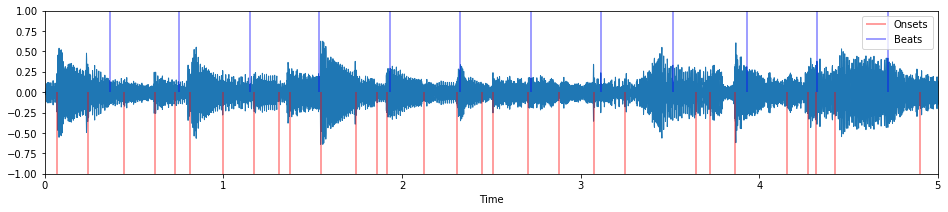

In [173]:
duration = 5
plt.figure(figsize=(16, 3))
librosa.display.waveplot(wav[:duration*sr], sr)
plt.ylim(-1, 1)
plt.vlines(onsets_times, -1, 0, color='r', alpha=0.5, label='Onsets')
plt.vlines(beats_times, 0, 1, color='b', alpha=0.5, label='Beats')
plt.legend();

We can see that the beats are quite close to some of the onsets, and we want to select those.

In [174]:
dist = np.min(np.abs(onsets_times[:, np.newaxis] - beats_times), axis=1)
onsets_selected = onsets[dist < delta]

Let's visualise which onsets we selected:

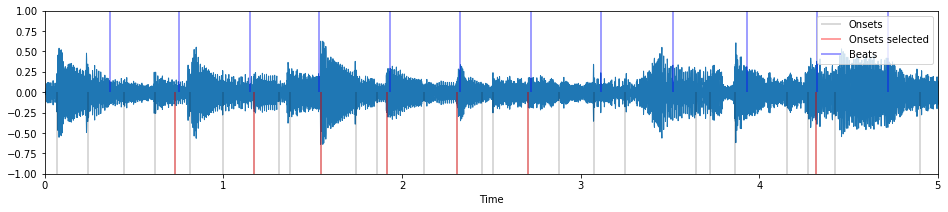

In [175]:
duration = 5
onsets_selected_times = onsets_times[dist < delta]
plt.figure(figsize=(16, 3))
librosa.display.waveplot(wav[:duration*sr], sr)
plt.ylim(-1, 1)
plt.vlines(onsets_times, -1, 0, color='k', alpha=0.2, label='Onsets')
plt.vlines(onsets_selected_times, -1, 0, color='r', alpha=0.5, label='Onsets selected')
plt.vlines(beats_times, 0, 1, color='b', alpha=0.5, label='Beats')
plt.legend();

Good. That's exactly what we wanted.

We then store a `csv` file containing the onsets (in frames) in one column and whether it is selected as a first beat in another column.

We must first create the `./data/GTZAN/onsets/` directory, if it doesn't exist.

In [176]:
df = pd.DataFrame()
df['onsets'] = onsets
df['isbeat'] = (dist < delta).astype(np.int)
df.head()

onsets  isbeat
0       6       0
1      21       0
2      38       0
3      53       0
4      63       1

In [177]:
df.to_csv(filename_onset(s, n), index=False)
print(f"Wrote file: {filename_onset(s, n)}")

Wrote file: ./data/GTZAN/onsets/blues.00033.csv


### All files

Now that we know what we are doing, let's do it for all files. This can take several minutes.

In [2]:
import librosa
import numpy as np
import pandas as pd
import jams

def load_beats(style, number):
    df = jams.load(filename_rhythm(style, number))['annotations'][0].to_dataframe()
    return df['time'].values

sr = 44100
hl = 512
delta = 0.03

In [3]:
for s in styles:
    for n in range(100):
        wav = librosa.load(filename_audio(s, n), sr)[0]
        onsets = librosa.onset.onset_detect(wav, sr, hop_length=hl)
        onsets_times = librosa.frames_to_time(onsets, sr, hl)
        beats_times = load_beats(s, n)
        dist = np.min(np.abs(onsets_times[:, np.newaxis] - beats_times), axis=1)
        onsets_selected = onsets[dist < delta]
        df = pd.DataFrame()
        df['onsets'] = onsets
        df['isbeat'] = (dist < delta).astype(np.int)
        df.to_csv(filename_onset(s, n), index=False)
        print(filename_onset(s, n))

./data/GTZAN/onsets/blues.00000.csv
./data/GTZAN/onsets/blues.00001.csv
./data/GTZAN/onsets/blues.00002.csv
./data/GTZAN/onsets/blues.00003.csv
./data/GTZAN/onsets/blues.00004.csv
./data/GTZAN/onsets/blues.00005.csv
./data/GTZAN/onsets/blues.00006.csv
./data/GTZAN/onsets/blues.00007.csv
./data/GTZAN/onsets/blues.00008.csv
./data/GTZAN/onsets/blues.00009.csv
./data/GTZAN/onsets/blues.00010.csv
./data/GTZAN/onsets/blues.00011.csv
./data/GTZAN/onsets/blues.00012.csv
./data/GTZAN/onsets/blues.00013.csv
./data/GTZAN/onsets/blues.00014.csv
./data/GTZAN/onsets/blues.00015.csv
./data/GTZAN/onsets/blues.00016.csv
./data/GTZAN/onsets/blues.00017.csv
./data/GTZAN/onsets/blues.00018.csv
./data/GTZAN/onsets/blues.00019.csv
./data/GTZAN/onsets/blues.00020.csv
./data/GTZAN/onsets/blues.00021.csv
./data/GTZAN/onsets/blues.00022.csv
./data/GTZAN/onsets/blues.00023.csv
./data/GTZAN/onsets/blues.00024.csv
./data/GTZAN/onsets/blues.00025.csv
./data/GTZAN/onsets/blues.00026.csv
./data/GTZAN/onsets/blues.00

./data/GTZAN/onsets/country.00016.csv
./data/GTZAN/onsets/country.00017.csv
./data/GTZAN/onsets/country.00018.csv
./data/GTZAN/onsets/country.00019.csv
./data/GTZAN/onsets/country.00020.csv
./data/GTZAN/onsets/country.00021.csv
./data/GTZAN/onsets/country.00022.csv
./data/GTZAN/onsets/country.00023.csv
./data/GTZAN/onsets/country.00024.csv
./data/GTZAN/onsets/country.00025.csv
./data/GTZAN/onsets/country.00026.csv
./data/GTZAN/onsets/country.00027.csv
./data/GTZAN/onsets/country.00028.csv
./data/GTZAN/onsets/country.00029.csv
./data/GTZAN/onsets/country.00030.csv
./data/GTZAN/onsets/country.00031.csv
./data/GTZAN/onsets/country.00032.csv
./data/GTZAN/onsets/country.00033.csv
./data/GTZAN/onsets/country.00034.csv
./data/GTZAN/onsets/country.00035.csv
./data/GTZAN/onsets/country.00036.csv
./data/GTZAN/onsets/country.00037.csv
./data/GTZAN/onsets/country.00038.csv
./data/GTZAN/onsets/country.00039.csv
./data/GTZAN/onsets/country.00040.csv
./data/GTZAN/onsets/country.00041.csv
./data/GTZAN

./data/GTZAN/onsets/hiphop.00038.csv
./data/GTZAN/onsets/hiphop.00039.csv
./data/GTZAN/onsets/hiphop.00040.csv
./data/GTZAN/onsets/hiphop.00041.csv
./data/GTZAN/onsets/hiphop.00042.csv
./data/GTZAN/onsets/hiphop.00043.csv
./data/GTZAN/onsets/hiphop.00044.csv
./data/GTZAN/onsets/hiphop.00045.csv
./data/GTZAN/onsets/hiphop.00046.csv
./data/GTZAN/onsets/hiphop.00047.csv
./data/GTZAN/onsets/hiphop.00048.csv
./data/GTZAN/onsets/hiphop.00049.csv
./data/GTZAN/onsets/hiphop.00050.csv
./data/GTZAN/onsets/hiphop.00051.csv
./data/GTZAN/onsets/hiphop.00052.csv
./data/GTZAN/onsets/hiphop.00053.csv
./data/GTZAN/onsets/hiphop.00054.csv
./data/GTZAN/onsets/hiphop.00055.csv
./data/GTZAN/onsets/hiphop.00056.csv
./data/GTZAN/onsets/hiphop.00057.csv
./data/GTZAN/onsets/hiphop.00058.csv
./data/GTZAN/onsets/hiphop.00059.csv
./data/GTZAN/onsets/hiphop.00060.csv
./data/GTZAN/onsets/hiphop.00061.csv
./data/GTZAN/onsets/hiphop.00062.csv
./data/GTZAN/onsets/hiphop.00063.csv
./data/GTZAN/onsets/hiphop.00064.csv
.

./data/GTZAN/onsets/metal.00067.csv
./data/GTZAN/onsets/metal.00068.csv
./data/GTZAN/onsets/metal.00069.csv
./data/GTZAN/onsets/metal.00070.csv
./data/GTZAN/onsets/metal.00071.csv
./data/GTZAN/onsets/metal.00072.csv
./data/GTZAN/onsets/metal.00073.csv
./data/GTZAN/onsets/metal.00074.csv
./data/GTZAN/onsets/metal.00075.csv
./data/GTZAN/onsets/metal.00076.csv
./data/GTZAN/onsets/metal.00077.csv
./data/GTZAN/onsets/metal.00078.csv
./data/GTZAN/onsets/metal.00079.csv
./data/GTZAN/onsets/metal.00080.csv
./data/GTZAN/onsets/metal.00081.csv
./data/GTZAN/onsets/metal.00082.csv
./data/GTZAN/onsets/metal.00083.csv
./data/GTZAN/onsets/metal.00084.csv
./data/GTZAN/onsets/metal.00085.csv
./data/GTZAN/onsets/metal.00086.csv
./data/GTZAN/onsets/metal.00087.csv
./data/GTZAN/onsets/metal.00088.csv
./data/GTZAN/onsets/metal.00089.csv
./data/GTZAN/onsets/metal.00090.csv
./data/GTZAN/onsets/metal.00091.csv
./data/GTZAN/onsets/metal.00092.csv
./data/GTZAN/onsets/metal.00093.csv
./data/GTZAN/onsets/metal.00

./data/GTZAN/onsets/reggae.00098.csv
./data/GTZAN/onsets/reggae.00099.csv
./data/GTZAN/onsets/rock.00000.csv
./data/GTZAN/onsets/rock.00001.csv
./data/GTZAN/onsets/rock.00002.csv
./data/GTZAN/onsets/rock.00003.csv
./data/GTZAN/onsets/rock.00004.csv
./data/GTZAN/onsets/rock.00005.csv
./data/GTZAN/onsets/rock.00006.csv
./data/GTZAN/onsets/rock.00007.csv
./data/GTZAN/onsets/rock.00008.csv
./data/GTZAN/onsets/rock.00009.csv
./data/GTZAN/onsets/rock.00010.csv
./data/GTZAN/onsets/rock.00011.csv
./data/GTZAN/onsets/rock.00012.csv
./data/GTZAN/onsets/rock.00013.csv
./data/GTZAN/onsets/rock.00014.csv
./data/GTZAN/onsets/rock.00015.csv
./data/GTZAN/onsets/rock.00016.csv
./data/GTZAN/onsets/rock.00017.csv
./data/GTZAN/onsets/rock.00018.csv
./data/GTZAN/onsets/rock.00019.csv
./data/GTZAN/onsets/rock.00020.csv
./data/GTZAN/onsets/rock.00021.csv
./data/GTZAN/onsets/rock.00022.csv
./data/GTZAN/onsets/rock.00023.csv
./data/GTZAN/onsets/rock.00024.csv
./data/GTZAN/onsets/rock.00025.csv
./data/GTZAN/ons

## Test the postprocessing

We want to test how well will our algorithm work if the neural network has 100% accuracy.

In [16]:
s = np.random.choice(styles)
n = np.random.randint(100)
print(filename(s, n))

reggae.00090


In [17]:
wav = librosa.load(filename_audio(s, n), sr)[0]
df = pd.read_csv(filename_onset(s, n))
preds = df.onsets[df.isbeat == 1].values
env = np.zeros(len(wav) // hl)
env[preds] = 1
beats_times = load_beats(s, n)
tempo, beat_track = librosa.beat.beat_track(sr=sr, onset_envelope=env, hop_length=hl, tightness=800)

/home/paperspace/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


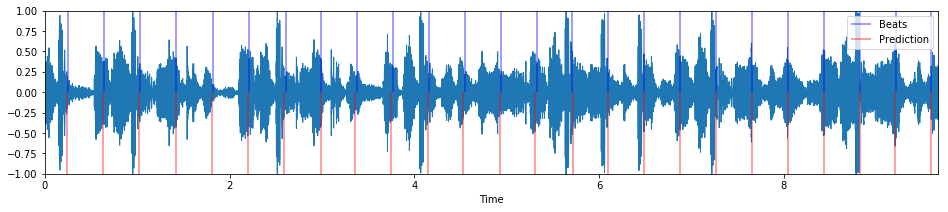

In [18]:
beat_track_times = librosa.frames_to_time(beat_track, sr, hl)
duration = 10
offset = np.random.rand()*25
plt.figure(figsize=(16, 3))
librosa.display.waveplot(wav[int(offset*sr):int((offset+duration)*sr)], sr)
plt.ylim(-1, 1)
plt.vlines(beats_times, 0, 1, color='b', alpha=0.5, label='Beats')
plt.vlines(beat_track_times, -1, 0, color='r', alpha=0.5, label='Prediction')
plt.legend();

We can also listen to the result:

In [19]:
clicks = librosa.clicks(frames=beat_track, sr=sr, hop_length=hl, length=len(wav))
Audio(wav + clicks, rate=sr)

## Compute the spectrograms

### An example

We keep with the example above.

In [ ]:
s = 'jazz'
n = 37

In [20]:
wav = librosa.load(filename_audio(s, n), sr)[0]

In [161]:
def preprocess(spec, scaling_factor=1000):
    spec = np.log(scaling_factor * spec + 1)
    spec = spec / spec.max()
    spec = 2 * spec - 1
    return spec

In [178]:
n_mels = 128
fmax = 2**13
n_fft = 2**11
spec = librosa.feature.melspectrogram(wav, sr, n_mels=n_mels, n_fft=n_fft, hop_length=hl)
spec = preprocess(spec)

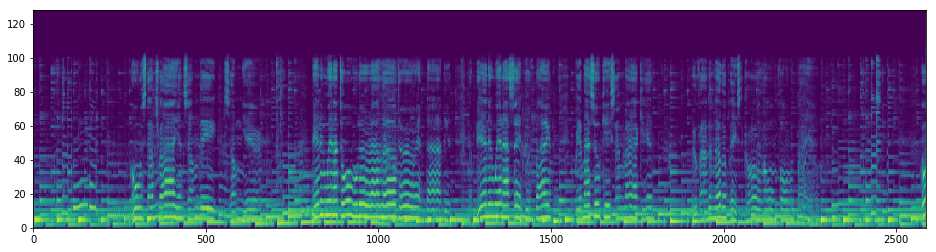

In [179]:
plt.figure(figsize=(16, 4))
plt.pcolormesh(spec);

Make sure the directory
```
./data/GTZAN/specs
```
is created.

In [180]:
np.save(filename_spec(s, n), spec)
print("Spectograms written in", filename_spec(s, n))

Spectograms written in ./data/GTZAN/specs/blues.00033.npy


### All files

In [184]:
n_mels = 128
fmax   = 8192
n_fft  = 2048

def preprocess(spec, scaling_factor=50):
    spec = np.log(scaling_factor * spec + 1)
    spec = spec / spec.max()
    spec = 2 * spec - 1
    return spec

In [186]:
for s in styles:
    for n in range(100):
        wav = librosa.load(filename_audio(s, n), sr)[0]
        spec = librosa.feature.melspectrogram(wav, sr, n_mels=n_mels, n_fft=n_fft, hop_length=hl)
        spec = preprocess(spec)
        np.save(filename_spec(s, n), spec)
        print(filename(s, n))

blues.00000
blues.00001
blues.00002
blues.00003
blues.00004
blues.00005
blues.00006
blues.00007
blues.00008
blues.00009
blues.00010
blues.00011
blues.00012
blues.00013
blues.00014
blues.00015
blues.00016
blues.00017
blues.00018
blues.00019
blues.00020
blues.00021
blues.00022
blues.00023
blues.00024
blues.00025
blues.00026
blues.00027
blues.00028
blues.00029
blues.00030
blues.00031
blues.00032
blues.00033
blues.00034
blues.00035
blues.00036
blues.00037
blues.00038
blues.00039
blues.00040
blues.00041
blues.00042
blues.00043
blues.00044
blues.00045
blues.00046
blues.00047
blues.00048
blues.00049
blues.00050
blues.00051
blues.00052
blues.00053
blues.00054
blues.00055
blues.00056
blues.00057
blues.00058
blues.00059
blues.00060
blues.00061
blues.00062
blues.00063
blues.00064
blues.00065
blues.00066
blues.00067
blues.00068
blues.00069
blues.00070
blues.00071
blues.00072
blues.00073
blues.00074
blues.00075
blues.00076
blues.00077
blues.00078
blues.00079
blues.00080
blues.00081
blues.00082
blue

metal.00033
metal.00034
metal.00035
metal.00036
metal.00037
metal.00038
metal.00039
metal.00040
metal.00041
metal.00042
metal.00043
metal.00044
metal.00045
metal.00046
metal.00047
metal.00048
metal.00049
metal.00050
metal.00051
metal.00052
metal.00053
metal.00054
metal.00055
metal.00056
metal.00057
metal.00058
metal.00059
metal.00060
metal.00061
metal.00062
metal.00063
metal.00064
metal.00065
metal.00066
metal.00067
metal.00068
metal.00069
metal.00070
metal.00071
metal.00072
metal.00073
metal.00074
metal.00075
metal.00076
metal.00077
metal.00078
metal.00079
metal.00080
metal.00081
metal.00082
metal.00083
metal.00084
metal.00085
metal.00086
metal.00087
metal.00088
metal.00089
metal.00090
metal.00091
metal.00092
metal.00093
metal.00094
metal.00095
metal.00096
metal.00097
metal.00098
metal.00099
pop.00000
pop.00001
pop.00002
pop.00003
pop.00004
pop.00005
pop.00006
pop.00007
pop.00008
pop.00009
pop.00010
pop.00011
pop.00012
pop.00013
pop.00014
pop.00015
pop.00016
pop.00017
pop.00018
pop.00